In [1]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

Using TensorFlow backend.


In [2]:
# 此函數會幫我們把多張影像畫成一張多宮格圖
def img_combine(img, ncols=8, size=1, path=False):
    from math import ceil
    import matplotlib.pyplot as plt
    import numpy as np
    nimg = len(img)
    nrows = int(ceil(nimg/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*size,nrows*size))
    if nrows == 0:
        return
    elif ncols == 1:
        for r, ax in zip(np.arange(nrows), axes):
            nth=r
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                
            ax.set_axis_off()
    elif nrows == 1:
        for c, ax in zip(np.arange(ncols), axes):
            nth=c
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
            ax.set_axis_off()
    else:
        for r, row in zip(np.arange(nrows), axes):
            for c, ax in zip(np.arange(ncols), row):
                nth=r*ncols+c
                if nth < nimg:
                    ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                ax.set_axis_off()
    plt.show()

In [3]:
# 讀取 Cifar-10 資料集
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

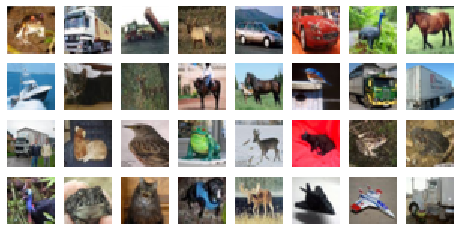

In [4]:
# 取前 32 張圖片做視覺化
images = x_train[:32]
img_combine(images)

In [5]:
# 建立 ImageDataGenerator，並指定我們要做資料增強的數值範圍
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

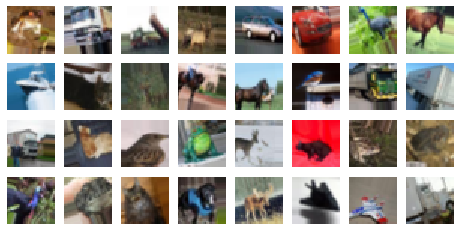

In [6]:
# 注意！！ ImageDataGenerator 是一個 Generator (生成器)! 對 Generator 不熟悉的同學請回到 Day098 做複習。
# 使用 .flow 後，就會對我們的影像進行增強，再 call next 取出 generator 的圖像。(shuffle=False 因為我們希望圖像的順序不要改變，方便觀察。實際訓練時預設是 shuffle=True) 
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int")) # 注意在訓練時神經網路時，圖像資料必須要是 float32，但在做視覺化時要轉為 int 才能順利畫圖。所以為了畫圖才把資料轉為 int

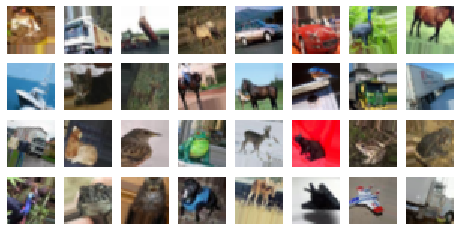

In [7]:
# 因為隨機性的關係，所以一樣的圖像再經過一次 generator 後的結果不一定相同
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int"))

## 作業

請使用 ImageDataGenerator 來進行 Cifar-10 資料集的訓練，並觀察不同的圖像增強方法是否會顯著影響訓練結果

In [8]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adam
import os

In [9]:
batch_size = 128 # batch 的大小，如果出現 OOM error，請降低這個值
num_classes = 10 # 類別的數量，Cifar 10 共有 10 個類別
epochs = 10 # 訓練的 epochs 數量

# 讀取資料並檢視
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# 對 label 進行 one-hot encoding (y_trian 原本是純數字)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [10]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [11]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

datagen = ImageDataGenerator()
datagen.fit(x_train)

model.fit_generator(datagen.flow(x_train, y_train,
                    batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    steps_per_epoch=10,
                    workers=4)

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

W0805 22:54:17.330701  8168 deprecation_wrapper.py:119] From C:\Users\shoey\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0805 22:54:17.348702  8168 deprecation_wrapper.py:119] From C:\Users\shoey\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0805 22:54:17.351702  8168 deprecation_wrapper.py:119] From C:\Users\shoey\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0805 22:54:17.374703  8168 deprecation_wrapper.py:119] From C:\Users\shoey\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0805 22:54:17.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

W0805 22:54:20.586887  8168 deprecation.py:323] From C:\Users\shoey\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
10/10 [==============================] - 7s 706ms/step - loss: 2.3208 - acc: 0.1219 - val_loss: 2.2718 - val_acc: 0.1278
Epoch 2/10
10/10 [==============================] - 6s 612ms/step - loss: 2.3144 - acc: 0.1625 - val_loss: 2.2599 - val_acc: 0.1401
Epoch 3/10
10/10 [==============================] - 6s 591ms/step - loss: 2.2770 - acc: 0.1414 - val_loss: 2.2526 - val_acc: 0.1277
Epoch 4/10
10/10 [==============================] - 6s 568ms/step - loss: 2.2016 - acc: 0.1789 - val_loss: 2.0705 - val_acc: 0.2672
Epoch 5/10
10/10 [==============================] - 6s 631ms/step - loss: 2.1608 - acc: 0.2156 - val_loss: 2.0434 - val_acc: 0.2510
Epoch 6/10
10/10 [==============================] - 6s 579ms/step - loss: 2.0318 - acc: 0.2687 - val_loss: 2.0671 - val_acc: 0.2570
Epoch 7/10
10/10 [==============================] - 6s 552ms/step - loss: 2.0790 - acc: 0.2672 - val_loss: 2.2610 - val_acc: 0.1875
Epoch 8/10
10/10 [==============================] - 6s 562ms/step - loss: 1.

In [12]:
# 建立 ImageDataGenerator，並指定我們要做資料增強的數值範圍
data_generator = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True)
data_generator.fit(x_train)

model.fit_generator(data_generator.flow(x_train, y_train,
                    batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    steps_per_epoch=10,
                    workers=4)

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
10/10 [==============================] - 6s 608ms/step - loss: 2.0259 - acc: 0.2617 - val_loss: 2.0054 - val_acc: 0.2446
Epoch 2/10
10/10 [==============================] - 6s 592ms/step - loss: 2.1381 - acc: 0.2227 - val_loss: 1.8244 - val_acc: 0.3424
Epoch 3/10
10/10 [==============================] - 6s 562ms/step - loss: 2.0823 - acc: 0.2227 - val_loss: 1.7979 - val_acc: 0.3711
Epoch 4/10
10/10 [==============================] - 6s 566ms/step - loss: 2.0726 - acc: 0.2422 - val_loss: 1.9380 - val_acc: 0.3039
Epoch 5/10
10/10 [==============================] - 6s 558ms/step - loss: 2.0756 - acc: 0.2398 - val_loss: 1.8554 - val_acc: 0.3725
Epoch 6/10
10/10 [==============================] - 6s 569ms/step - loss: 2.0188 - acc: 0.2484 - val_loss: 1.9036 - val_acc: 0.3075
Epoch 7/10
10/10 [==============================] - 6s 558ms/step - loss: 2.0297 - acc: 0.2602 - val_loss: 1.8182 - val_acc: 0.3503
Epoch 8/10
10/10 [==============================] - 6s 560ms/step - loss: 2.